In [1]:
# Unifying annotation and candidate data

from collections import namedtuple

# Unified interface to the human-annotated data
CandidateInfoTuple = namedtuple(
    "CandidateInfoTuple",
    "isNodule_bool, diameter_mm, series_uid, center_xyz"
)

CandidateInfoTuple

__main__.CandidateInfoTuple

In [2]:
# Caching utils

import gzip

from diskcache import FanoutCache, Disk,core
from diskcache.core import io
from io import BytesIO
from diskcache.core import MODE_BINARY

import logging
log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)


class GzipDisk(Disk):
    def store(self, value, read, key=None):
        """
        Override from base class diskcache.Disk.
        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.
        :param value: value to convert
        :param bool read: True when value is file-like object
        :return: (size, mode, filename, value) tuple for Cache table
        """
        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesIO:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        """
        Override from base class diskcache.Disk.
        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.
        :param int mode: value mode raw, binary, text, or pickle
        :param str filename: filename of corresponding value
        :param value: database value
        :param bool read: when True, return an open file handle
        :return: corresponding Python value
        """
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value
    

def getCache(scope_str):
    return FanoutCache('data-unversioned/cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
            )

In [3]:
# NOTE: can't help but feel this would be far neater using pandas
# Maybe should refactor?

import functools
import glob
import csv
from diskcache import FanoutCache, Disk

@functools.lru_cache(1) # Standard library in-memory caching
def getCandidateInfoList(requireOnDisk_bool=True):
    """
    The requireOnDisk_bool parameter means we’re detecting which LUNA
    series UIDs are actually present and ready to be loaded from disk.
    This information is used to limit which entries we use from the CSV
    files we’re about to parse. This allows us to run a subset of the data
    (that available once loaded) through the training loop.
    
    Since parting some of the data files can be slow, the results of this
    function are cached in memory using the above decorator.
    """
    mhd_list = glob.glob("../data/luna/subset*/*.mhd")
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}
    
    # Merge diameter information from annotations.csv
    diameter_dict = {}
    with open('../data/luna/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )

    # Build full list of candidates using candidates.csv                
    candidateInfo_list = []
    with open("../data/luna/candidates.csv", "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            # If a series_uid isn’t present, it’s in a subset we don’t have on disk
            # so we should skip it.
            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    """
                    Divide the diameter by 2 to get the radius, and divide 
                    the radius by 2 to require that the two nodule center points
                    not be too far apart relative to the size of the nodule.
                    (This results in a bounding-box check, not a true distance check.)
                    """
                    if delta_mm > annotationDiameter_mm / 4:
                        break
                    else:
                        candidateDiameter_mm = annotationDiameter_mm
                        break

                candidateInfo_list.append(CandidateInfoTuple(
                    isNodule_bool,
                    candidateDiameter_mm,
                    series_uid,
                    candidateCenter_xyz
                ))
    
    # sort and return data
    candidateInfo_list.sort(reverse=True) # nodule samples start with largest first
    return candidateInfo_list


@functools.lru_cache(1)
def getCandidateInfoDict(requireOnDisk_bool=True):
    candidateInfo_list = getCandidateInfoList(requireOnDisk_bool)
    candidateInfo_dict = {}

    for candidateInfo_tup in candidateInfo_list:
        candidateInfo_dict.setdefault(candidateInfo_tup.series_uid,
                                      []).append(candidateInfo_tup)

    return candidateInfo_dict


raw_cache = getCache('part2ch10_raw')

@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

In [4]:
# Use SimpleITK to convert MetaIO CT files into numpy arrays

import numpy as np
import SimpleITK as sitk

class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            '../data/luna/subset*/{}.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        self.hu_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.

        self.series_uid = series_uid

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

        candidateInfo_list = getCandidateInfoDict()[self.series_uid]

        self.positiveInfo_list = [
            candidate_tup
            for candidate_tup in candidateInfo_list
            if candidate_tup.isNodule_bool
        ]
        self.positive_mask = self.buildAnnotationMask(self.positiveInfo_list)
        self.positive_indexes = (self.positive_mask.sum(axis=(1,2))
                                 .nonzero()[0].tolist())

    def buildAnnotationMask(self, positiveInfo_list, threshold_hu = -700):
        boundingBox_a = np.zeros_like(self.hu_a, dtype=np.bool)

        for candidateInfo_tup in positiveInfo_list:
            center_irc = xyz2irc(
                candidateInfo_tup.center_xyz,
                self.origin_xyz,
                self.vxSize_xyz,
                self.direction_a,
            )
            ci = int(center_irc.index)
            cr = int(center_irc.row)
            cc = int(center_irc.col)

            index_radius = 2
            try:
                while self.hu_a[ci + index_radius, cr, cc] > threshold_hu and \
                        self.hu_a[ci - index_radius, cr, cc] > threshold_hu:
                    index_radius += 1
            except IndexError:
                index_radius -= 1

            row_radius = 2
            try:
                while self.hu_a[ci, cr + row_radius, cc] > threshold_hu and \
                        self.hu_a[ci, cr - row_radius, cc] > threshold_hu:
                    row_radius += 1
            except IndexError:
                row_radius -= 1

            col_radius = 2
            try:
                while self.hu_a[ci, cr, cc + col_radius] > threshold_hu and \
                        self.hu_a[ci, cr, cc - col_radius] > threshold_hu:
                    col_radius += 1
            except IndexError:
                col_radius -= 1

            # assert index_radius > 0, repr([candidateInfo_tup.center_xyz, center_irc, self.hu_a[ci, cr, cc]])
            # assert row_radius > 0
            # assert col_radius > 0

            boundingBox_a[
                 ci - index_radius: ci + index_radius + 1,
                 cr - row_radius: cr + row_radius + 1,
                 cc - col_radius: cc + col_radius + 1] = True

        mask_a = boundingBox_a & (self.hu_a > threshold_hu)

        return mask_a

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc


In [5]:
# Conversion from patient coordinates array coordinates, and reverse

import collections

IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    # Swap the order while we convert to numpy array
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    # Inverse of before
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

In [6]:
import torch
from torch.utils.data import Dataset
import copy
import os
import logging

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
            ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())

        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]

        # Train/validation split
        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list

        log.info("{!r}: {} {} samples".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        candidateInfo_tup = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)

        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )

        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

        return ( # training example
            candidate_t,
            pos_t,
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc),
        )


In [7]:
# Final sample tuple (nodule_t output isn't readable)

LunaDataset()[0]

(tensor([[[[-880., -846., -825.,  ..., -812., -772., -723.],
           [-862., -805., -813.,  ..., -833., -829., -801.],
           [-795., -770., -819.,  ..., -830., -808., -804.],
           ...,
           [-859., -858., -882.,  ...,  -35.,   -4.,   11.],
           [-883., -878., -876.,  ...,    0.,  -13.,  -35.],
           [-878., -845., -816.,  ...,    2.,  -15.,  -38.]],
 
          [[-924., -914., -879.,  ..., -794., -732., -638.],
           [-897., -881., -858.,  ..., -821., -787., -741.],
           [-884., -877., -875.,  ..., -824., -808., -811.],
           ...,
           [-891., -868., -784.,  ...,  -80.,  -99., -109.],
           [-887., -856., -759.,  ...,  -69.,  -83.,  -84.],
           [-884., -835., -766.,  ..., -103., -102., -100.]],
 
          [[-843., -843., -857.,  ..., -846., -837., -857.],
           [-862., -854., -864.,  ..., -844., -821., -831.],
           [-861., -843., -831.,  ..., -815., -807., -816.],
           ...,
           [-857., -789., -707.

## Dataset exploration

In [8]:
"""
We have a few very large candidates, starting at 32 mm, but they rapidly drop off to
half that size. The bulk of the candidates are in the 4 to 10 mm range, and several
hundred don’t have size information at all.
"""

candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
positiveInfo_list = [x for x in candidateInfo_list if x[0]]
diameter_list = [x[1] for x in positiveInfo_list]

for i in range(0, len(diameter_list), 100):
    print('{:4} {:4.1f} mm'.format(i, diameter_list[i]))

   0 32.3 mm
 100 23.0 mm
 200 19.7 mm
 300 17.6 mm
 400 15.1 mm
 500 13.1 mm
 600 11.8 mm
 700 10.4 mm
 800  9.4 mm
 900  8.7 mm
1000  8.0 mm
1100  7.6 mm
1200  7.0 mm
1300  6.8 mm
1400  6.4 mm
1500  6.2 mm
1600  6.0 mm
1700  5.7 mm
1800  5.5 mm
1900  5.2 mm
2000  5.1 mm
2100  4.8 mm
2200  4.7 mm
2300  4.4 mm
2400  4.1 mm
2500  0.0 mm
2600  0.0 mm
2700  0.0 mm
2800  0.0 mm
2900  0.0 mm
3000  0.0 mm
3100  0.0 mm
3200  0.0 mm
3300  0.0 mm
3400  0.0 mm
3500  0.0 mm
3600  0.0 mm
3700  0.0 mm
3800  0.0 mm
3900  0.0 mm


In [9]:
# Data visualisation helpers

clim=(-1000.0, 300)

def findPositiveSamples(start_ndx=0, limit=100):
    ds = LunaDataset()

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)

0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(75.7212243102, 92.8873310394, -119.270564052))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(75.7212243102, 92.8873310394, -119.270564052))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(75.2239949525, 79.4552680171, -121.430168337))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(75.2239949525, 79.4552680171, -121.430168337))
4 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(70.8583605372, 73.395451154

1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886 0 False [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


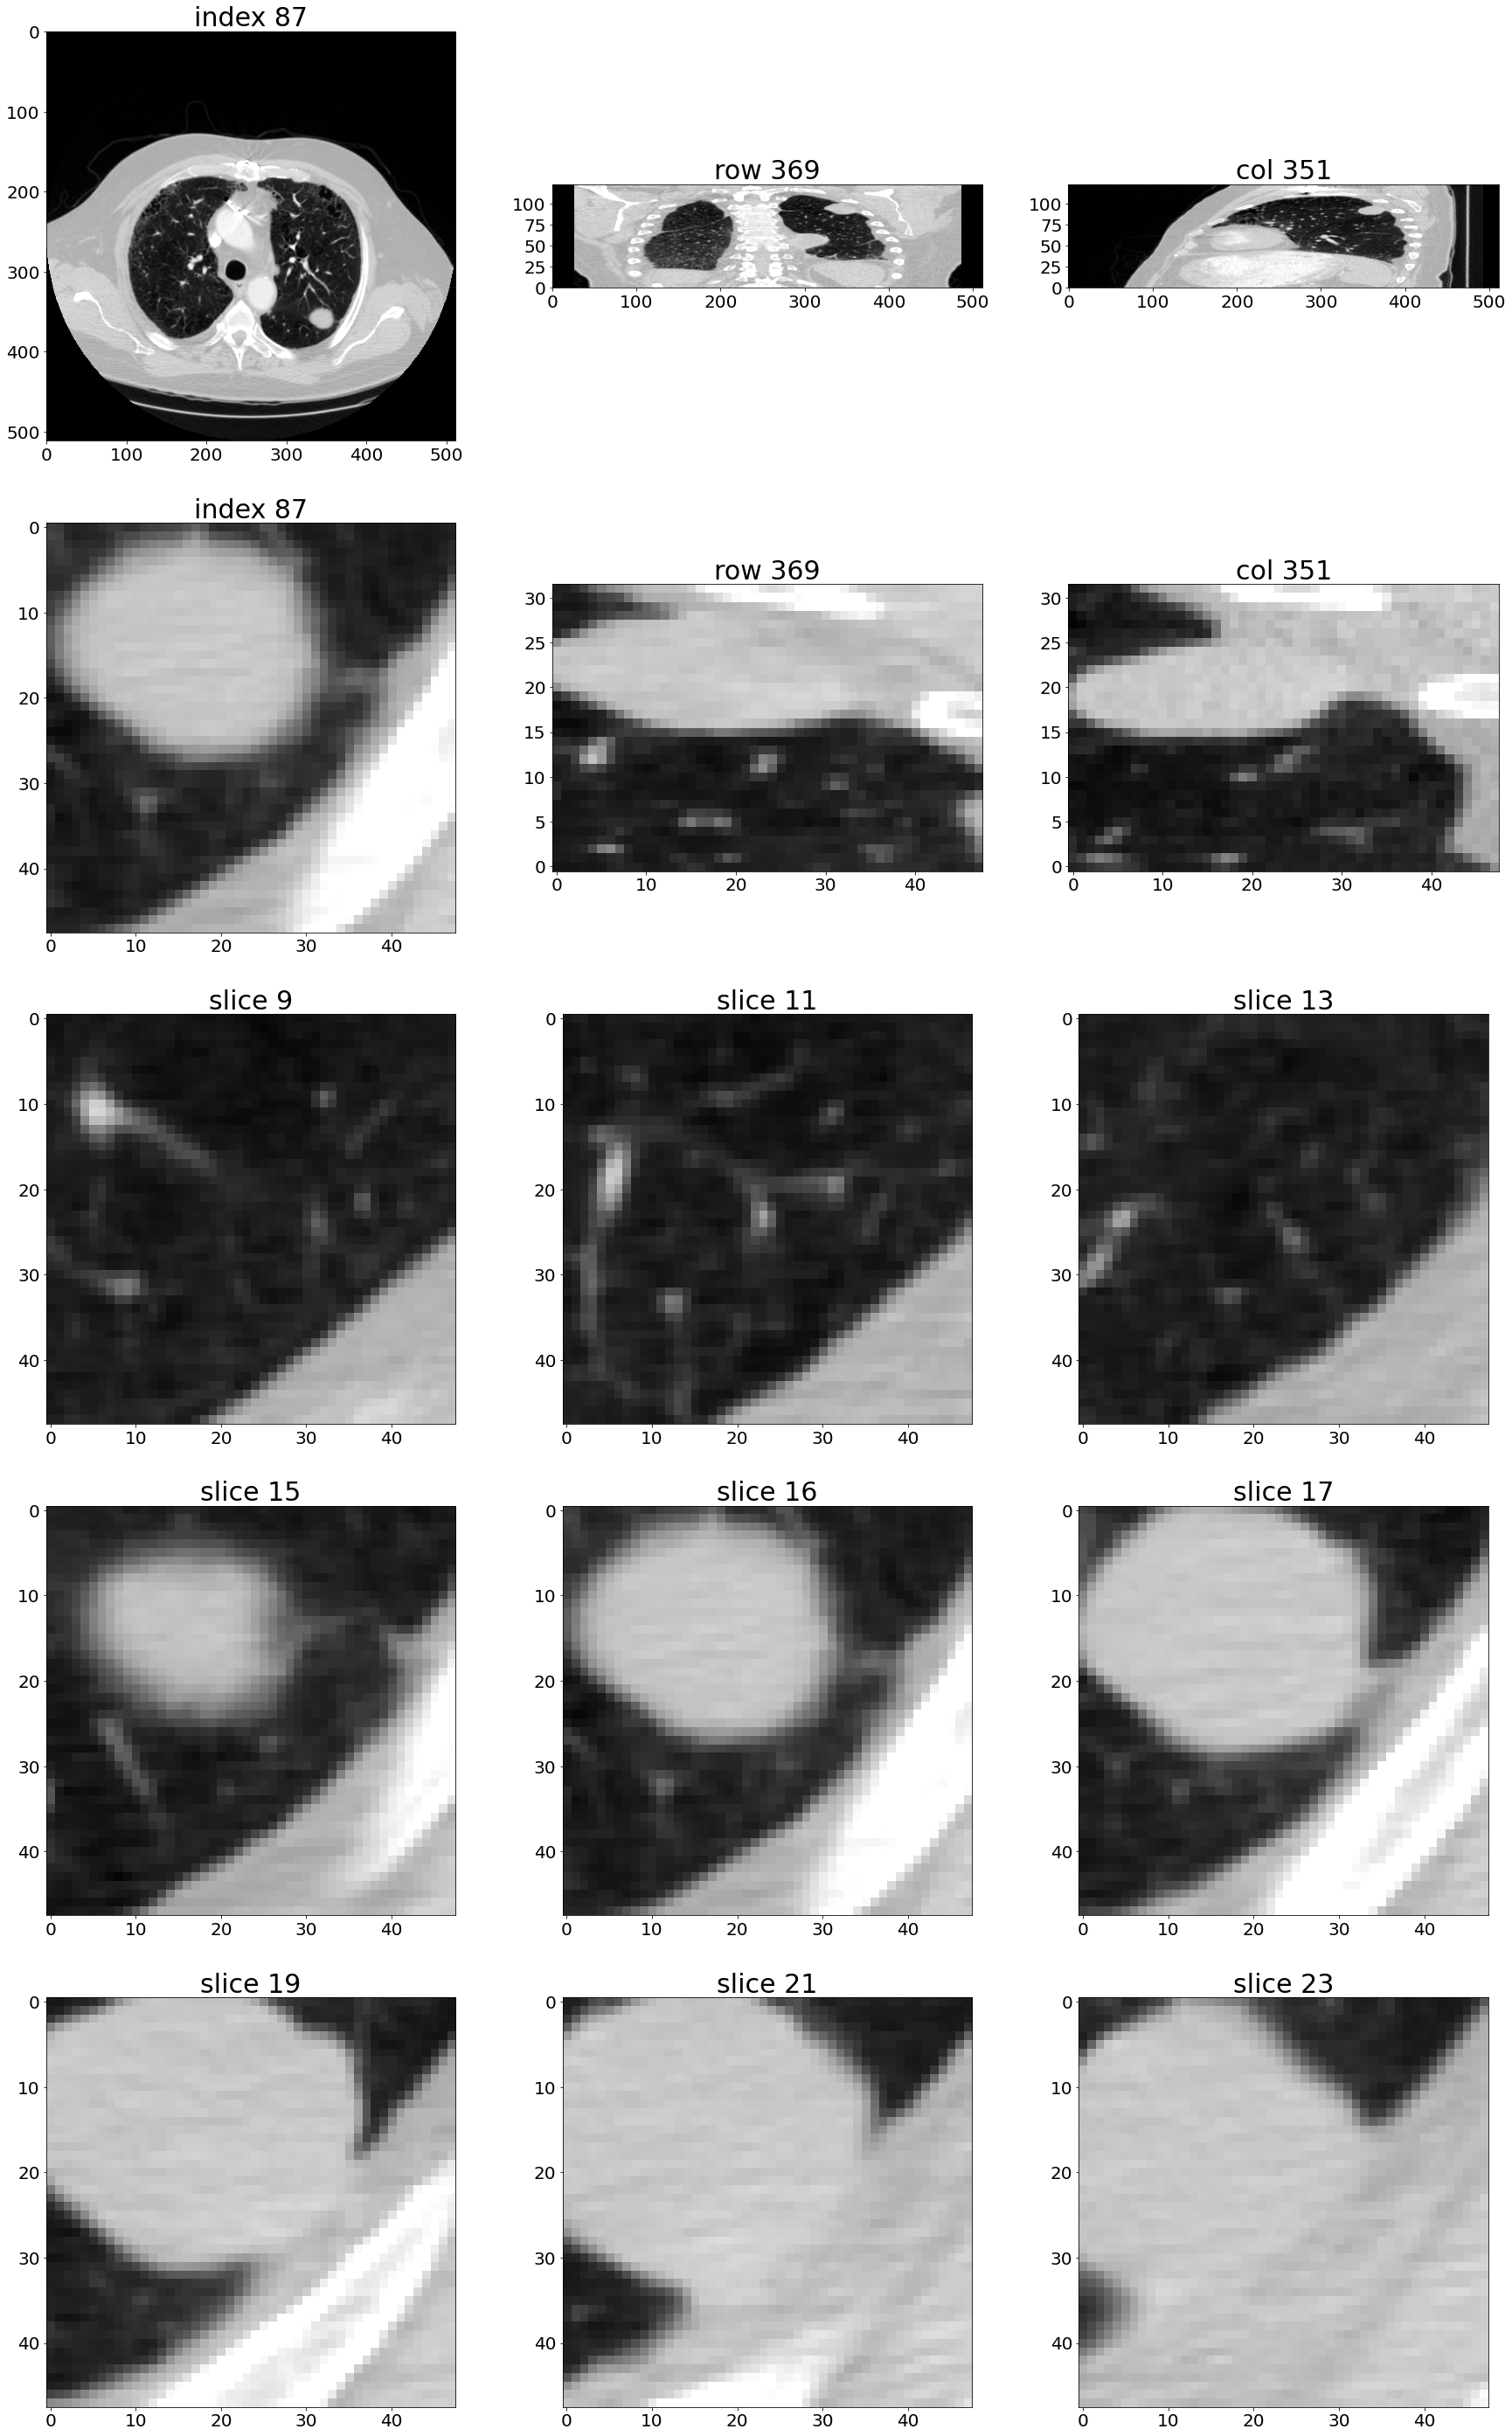

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline
positiveSample_list = findPositiveSamples()

series_uid = positiveSample_list[11][2]
showCandidate(series_uid)

## Chapter Exercises

In [11]:
import time

ds = LunaDataset()

start_time = time.time()

for item in ds:
    example = item

end_time = time.time()

print(f"First iteration took {round(end_time - start_time, 2)} seconds.")

start_time = time.time()

for item in ds:
    example = item

end_time = time.time()

print(f"Second iteration took {round(end_time - start_time, 2)} seconds, thanks to caching.")

First iteration took 3514.89 seconds.
Second iteration took 555.12 seconds, thanks to caching.


In [14]:
# Cached data is stored in ./data-unversioned. Rm to clear.

! ls
! rm -rf ./data-unversioned

Step1-DataLoading.ipynb  Step2-TrainingLoop.ipynb  data-unversioned


In [15]:
# Clear cache and reassess

start_time = time.time()

for item in ds:
    example = item

end_time = time.time()

print(f"One iteration took {round(end_time - start_time, 2)} seconds, after cache clearing.")

One iteration took 3304.43 seconds, after cache clearing.
